In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

## 1. Load the titanic train and test data

In [2]:
# create the dataframes
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# preview data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2.Data analysis

In [3]:
# See the shape of our datasets
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
# Missing columns data
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### Fare

In [7]:
# Fill the missing value
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

train['Fare'] = train['Fare'].astype(int)
test['Fare'] = test['Fare'].astype(int)

### Age

In [8]:
# The idea of using the mean and standard deviation is based 
# on this kernel https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic
train_avg_age = train['Age'].mean()
train_std_age = train['Age'].std()

test_avg_age = test['Age'].mean()
test_std_age = test['Age'].std()

# Generate random numbers between (mean - std) and (mean + std)
# to fill the empty age columns
# The generated age values will be in the
# interquatile range, removing all possible outliers
rand_train = np.random.randint(train_avg_age - train_std_age, train_avg_age + train_std_age,
                              train['Age'].isnull().sum())
rand_test = np.random.randint(test_avg_age - test_std_age, test_avg_age + test_std_age,
                              test['Age'].isnull().sum())

# fill "NaN" values in empty Age columns
train['Age'][np.isnan(train['Age'])] = rand_train
test['Age'][np.isnan(test['Age'])] = rand_test

# Now that we haven't missing values we can
# use Age as int instead float
train['Age'] = train['Age'].astype(int)
test['Age'] = test['Age'].astype(int)

/home/denisovitch/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/denisovitch/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Family

/home/denisovitch/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


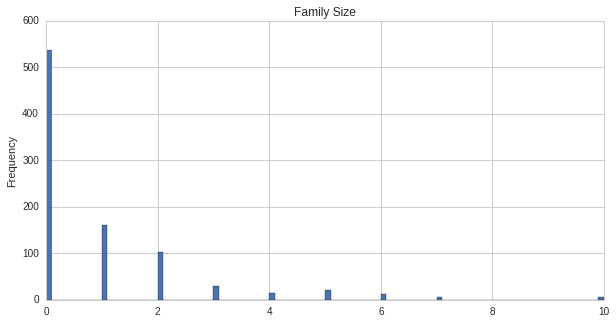

In [9]:
# Family is made up of:
# sibsp = Number of Siblings/Spouses Aboard
# parch = Number of Parents/Children Aboard
train['Family'] = train['SibSp'] + train['Parch']

# visualize family size distribuition
train['Family'].plot(kind='hist', title='Family Size', figsize=(10,5),bins=100, xlim=(0,10))

train['Family'].loc[train['Family'] > 0] = 1
train['Family'].loc[train['Family'] == 0] = 0

test['Family'] =  test["Parch"] + test["SibSp"]
test['Family'].loc[test['Family'] > 0] = 1
test['Family'].loc[test['Family'] == 0] = 0

# Sibling
train['Sibling'] = train['SibSp']
train['Sibling'].loc[train['Sibling'] > 0] = 1
train['Sibling'].loc[train['Sibling'] == 0] = 0

test['Sibling'] = test['SibSp']
test['Sibling'].loc[test['Sibling'] > 0] = 1
test['Sibling'].loc[test['Sibling'] == 0] = 0

# Parent
train['Parent'] = train['Parch']
train['Parent'].loc[train['Parent'] > 0] = 1
train['Parent'].loc[train['Parent'] == 0] = 0

test['Parent'] = test['Parch']
test['Parent'].loc[test['Parent'] > 0] = 1
test['Parent'].loc[test['Parent'] == 0] = 0

# drop Parch & SibSp from dataframes
train = train.drop(['SibSp','Parch'], axis=1)
test = test.drop(['SibSp','Parch'], axis=1)

### Sex
### New Predictor: Child

In [10]:
# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
train['Person'] = train[['Age','Sex']].apply(get_person,axis=1)
test['Person']    = test[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
train.drop(['Sex'],axis=1,inplace=True)
test.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_titanic  = pd.get_dummies(train['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

train = train.join(person_dummies_titanic)
test    = test.join(person_dummies_test)

train['Child'] = train['Child'].astype(int)
test['Child'] = test['Child'].astype(int)

train['Female'] = train['Female'].astype(int)
test['Female'] = test['Female'].astype(int)

### Embarked

In [11]:
# From this we can see there're a lot of age columns with missing values
# Cabin has a lot of missing values, let's assume it doesn't play 
# a big rule in our predictions
train = train.drop(['PassengerId','Ticket','Cabin'], axis=1)
test    = test.drop(['Ticket','Cabin'], axis=1)

# fill the two missing values with the most occurred value (S)
train['Embarked'] = train['Embarked'].fillna("S")

# ?
embark_dummies_titanic  = pd.get_dummies(train['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

train = train.join(embark_dummies_titanic)
test    = test.join(embark_dummies_test)

train.drop(['Embarked'], axis=1,inplace=True)
test.drop(['Embarked'], axis=1,inplace=True)

train['C'] = train['C'].astype(int)
test['C'] = test['C'].astype(int)

train['Q'] = train['Q'].astype(int)
test['Q'] = test['Q'].astype(int)

### New Predictor: Title

In [12]:
# The .apply method generates a new series
train["NameLength"] = train["Name"].apply(lambda x: len(x))
test["NameLength"] = test["Name"].apply(lambda x: len(x))

"""
We can extract the title of the passenger from their name. The titles take
the form of Master., Mr., Mrs.. There are a few very commonly used titles, 
and a "long tail" of one-off titles that only one or two passengers have.
"""

import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return "other"

# Get all the titles and print how often each one occurs.
train_titles = train["Name"].apply(get_title)
test_titles = test["Name"].apply(get_title)

print(pd.value_counts(train_titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, 
                 "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8,
                 "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, 
                 "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 9, "other": 11}

for k,v in title_mapping.items():
    train_titles[train_titles == k] = v
    test_titles[test_titles == k] = v

# Add in the title column.
train["Title"] = train_titles
test['Title'] = test_titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Jonkheer      1
Countess      1
Mme           1
Don           1
Ms            1
Lady          1
Capt          1
Sir           1
Name: Name, dtype: int64


In [13]:
# Split down Classes to Binary values
# class_1, class_2, class_3

def class_1(class_n):
    if class_n == 1:
        return 1
    else:
        return 0

def class_2(class_n):
    if class_n == 2:
        return 1
    else:
        return 0
    
def class_3(class_n):
    if class_n == 3:
        return 1
    else:
        return 0
    
    
train['Class_1'] = train['Pclass'].apply(class_1)
train['Class_2'] = train['Pclass'].apply(class_2)
train['Class_3'] = train['Pclass'].apply(class_3)

test['Class_1'] = test['Pclass'].apply(class_1)
test['Class_2'] = test['Pclass'].apply(class_2)
test['Class_3'] = test['Pclass'].apply(class_3)


# train.drop(['Pclass'], axis=1,inplace=True)
# test.drop(['Pclass'], axis=1,inplace=True)

train.head()

,Survived,Pclass,Name,Age,Fare,Family,Sibling,Parent,Person,Child,Female,C,Q,NameLength,Title,Class_1,Class_2,Class_3
0,0,3,"Braund, Mr. Owen Harris",22,7,1,1,0,male,0,0,0,0,23,1,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38,71,1,1,0,female,0,1,1,0,51,3,1,0,0
2,1,3,"Heikkinen, Miss. Laina",26,7,0,0,0,female,0,1,0,0,22,2,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35,53,1,1,0,female,0,1,0,0,44,3,1,0,0
4,0,3,"Allen, Mr. William Henry",35,8,0,0,0,male,0,0,0,0,24,1,0,0,1


**Feature Selection: Simple analysis of the importance of each feature**

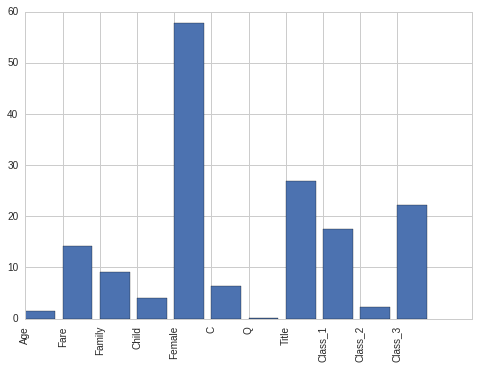

In [14]:
from sklearn.feature_selection import SelectKBest, f_classif
features = ['Age', 'Fare', 'Family', 'Child', 'Female', 'C', 'Q','Title', 'Class_1', 'Class_2', 'Class_3']

selector = SelectKBest(f_classif, k=11)
selector.fit(train[features], train["Survived"])

scores = -np.log10(selector.pvalues_)

plt.bar(range(len(features)), scores)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

### 3. Prepare the Model

In [15]:
# Now we're ready to build the machine learning model

# Predictors
# ['Pclass', 'Age', 'Sex', 'Fare', 'Embarked', 'Family', 'Title', 'Child', 'Class_1', 'Class_2', 'Class_3']
feature_train = ['Age', 'Fare', 'Family', 'Child', 'Female', 'C', 'Q', 'Title', 'Class_1', 'Class_2', 'Class_3']

X = train[feature_train] # instances to learn from
y = train['Survived'] # target/responses the model is trying to learn to predict

In [16]:
X.head() # this is the remaining features to use in the model

,Age,Fare,Family,Child,Female,C,Q,Title,Class_1,Class_2,Class_3
0,22,7,1,0,0,0,0,1,0,0,1
1,38,71,1,0,1,1,0,3,1,0,0
2,26,7,0,0,1,0,0,2,0,0,1
3,35,53,1,0,1,0,0,3,1,0,0
4,35,8,0,0,0,0,0,1,0,0,1


## Model: Random Forest Classifier

### Random Forest Parameter tuning

**NOTE:** GridSearch is computationaly expensive, Random Search would be preferable

### Use the best parameters to make predictions

In [17]:
forest = RandomForestClassifier(n_estimators=50, max_depth=9, 
        min_samples_split=7, min_samples_leaf=2)

scores = cross_val_score(forest, X, y, cv=10, scoring='accuracy')
print(scores)

# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

[ 0.77777778  0.82222222  0.76404494  0.85393258  0.85393258  0.85393258
  0.86516854  0.7752809   0.86516854  0.86363636]
0.829509703779


In [18]:
# Train the model
forest.fit(X, y)

# Make predictions
predictions = forest.predict(test[feature_train])

**Submit Random Forest**

In [19]:
# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })
submission.to_csv('random_forest_2017.csv', index=False)

### Review The model

This Model gave me about 0.78 on the Kaggle LB, I'm suspecting my model is overfitting but I stiil don't know Why?
I'll update this kernel with confusion matrix, ROC curve analysis and try adjust classifier perfomance before moving on to Neural Networks.